<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="./23_ltpy_Sentinel5p_L2_data.ipynb"><< 23 - Copernicus Sentinel-5 Precursor (Sentinel-5P) </a><span style="float:right;"><a href="./25_ltpy_Sentinel3_OLCI_L1.ipynb">25 - Sentinel-3 OLCI Level 1 data>></a></span>

# 2.4 Copernicus Atmosphere Monitoring Service (CAMS) data

The Copernicus Atmopshere Monitoring Service (CAMS) provides consistent and quality-controlled information related to air pollution and health and greenhouse gases. CAMS data consist of `global forecasts and analyses`, `global reanalyses`, `fire emissions` and `greenhouse gas flux inversions`.

#### Module outline:
* [1 - Load, browse and plot CAMS fire emissions data](#cams_gfas)
* [2 - Example - CAMS regional forecast data](#cams_regional)
* [3 - Load, browse and plot CAMS greenhouse gas flux inversions](#load_ggf)

#### Load required libraries

In [1]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.cm import get_cmap
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

In [11]:
from ipynb.fs.full.ltpy_functions import visualize_s5p_pcolormesh

<hr>

## <a id="cams_gfas"></a>Load, browse and plot CAMS fire emissions data

### Open a CAMS GFAS netCDF file with `xarray`

CAMS GFAS fire emission data can be retrieved in either `GRIB` or `NetCDF` format. With the Python library `xarray` and the `open_dataset` function, we can easily read a single `NetCDF` file.

CAMS GFAS fire emission data are three dimensional data, with the dimensions `latitude`, `longitude` and `time`. The data file loaded has three time steps, from 22 September to 24 September 2019 and a global spatial coverage. The xarray dataset contains a data variable called `frpfire`.

In [3]:
gfas_frpfire_xr = xr.open_dataset('./eodata/cams/gfas/20191022-24_gfas_radiative_power.nc')
gfas_frpfire_xr

<xarray.Dataset>
Dimensions:    (latitude: 1800, longitude: 3599, time: 3)
Coordinates:
  * longitude  (longitude) float32 -179.95 -179.85 -179.75 ... 179.75 179.85
  * latitude   (latitude) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time       (time) datetime64[ns] 2019-09-22 2019-09-23 2019-09-24
Data variables:
    frpfire    (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-10-09 09:34:26 GMT by grib_to_netcdf-2.13.0: grib_to_n...

We can select the data variable with `[]`, which gives us acces to the DataArray and more parameter attributes. Thus, the dataset values are `wildfire radiative power` and the parameter unit is `W m**-2`.

In [4]:
frpfire = gfas_frpfire_xr['frpfire']
frpfire

<xarray.DataArray 'frpfire' (time: 3, latitude: 1800, longitude: 3599)>
[19434600 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -179.95 -179.85 -179.75 ... 179.75 179.85
  * latitude   (latitude) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time       (time) datetime64[ns] 2019-09-22 2019-09-23 2019-09-24
Attributes:
    units:      W m**-2
    long_name:  Wildfire radiative power

With xarray's `where` function, we can build a geographical subset. Let's define a bounding box for south-east asia `[30,160,-20,80]` and subset the data. We see that the data has a negative _FillValue. Thus a next step is to filter negative values and set them to NaN.

In [5]:
latmin=-20
latmax=30
lonmin=80
lonmax=160
frpfire_subset = frpfire.where((frpfire.latitude < latmax) & (frpfire.latitude > latmin) & (frpfire.longitude < lonmax) & (frpfire.longitude > lonmin),drop=True)
frpfire_subset

<xarray.DataArray 'frpfire' (time: 3, latitude: 500, longitude: 800)>
array([[[-1.907349e-06, -1.907349e-06, ..., -1.907349e-06, -1.907349e-06],
        [-1.907349e-06, -1.907349e-06, ..., -1.907349e-06, -1.907349e-06],
        ...,
        [-1.907349e-06, -1.907349e-06, ..., -1.907349e-06, -1.907349e-06],
        [-1.907349e-06, -1.907349e-06, ..., -1.907349e-06, -1.907349e-06]],

       [[-1.907349e-06, -1.907349e-06, ..., -1.907349e-06, -1.907349e-06],
        [-1.907349e-06, -1.907349e-06, ..., -1.907349e-06, -1.907349e-06],
        ...,
        [-1.907349e-06, -1.907349e-06, ..., -1.907349e-06, -1.907349e-06],
        [-1.907349e-06, -1.907349e-06, ..., -1.907349e-06, -1.907349e-06]],

       [[-1.907349e-06, -1.907349e-06, ..., -1.907349e-06, -1.907349e-06],
        [-1.907349e-06, -1.907349e-06, ..., -1.907349e-06, -1.907349e-06],
        ...,
        [-1.907349e-06, -1.907349e-06, ..., -1.907349e-06, -1.907349e-06],
        [-1.907349e-06, -1.907349e-06, ..., -1.907349e-06, -1.

In [6]:
frpfire_subset.values[frpfire_subset.values<0]=np.nan
frpfire_subset

<xarray.DataArray 'frpfire' (time: 3, latitude: 500, longitude: 800)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 80.05 80.15 80.25 ... 159.75 159.85 159.95
  * latitude   (latitude) float32 29.95 29.85 29.75 ... -19.75 -19.85 -19.95
  * time       (time) datetime64[ns] 2019-09-22 2019-09-23 2019-09-24
Attributes:
    units:      W m**-2
    long_name:  Wildfire radiative power

### Visualize CAMS GFAS fire emissions data

You can use the function `visualize_s5p_pcolormesh` again. This time, you should set a logarithmic color scaling with setting `log_scale=True`. 
With `matplotlib.colors.ListedColorMap`, you can specify an individual color scale. Let's call the color scale `cmap` and plot the fire emissions data. Alternatively, you can use the predefine color scale `hot`.

In [7]:
cmap = matplotlib.colors.ListedColormap(['#330305','#620103','#880105','#B00602','#DA0302','#FF0907','#FD3304','#FF3106', 
                                  '#FF5A02', '#FC8706','#FDB004','#FADD02','#FFFF0C','#FEFF47','#FFFE85','#FFFEC5',
                                  '#FFFFFF'])

In [9]:
unit = frpfire.units
longname= frpfire.long_name

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x11f5a6eb8>)

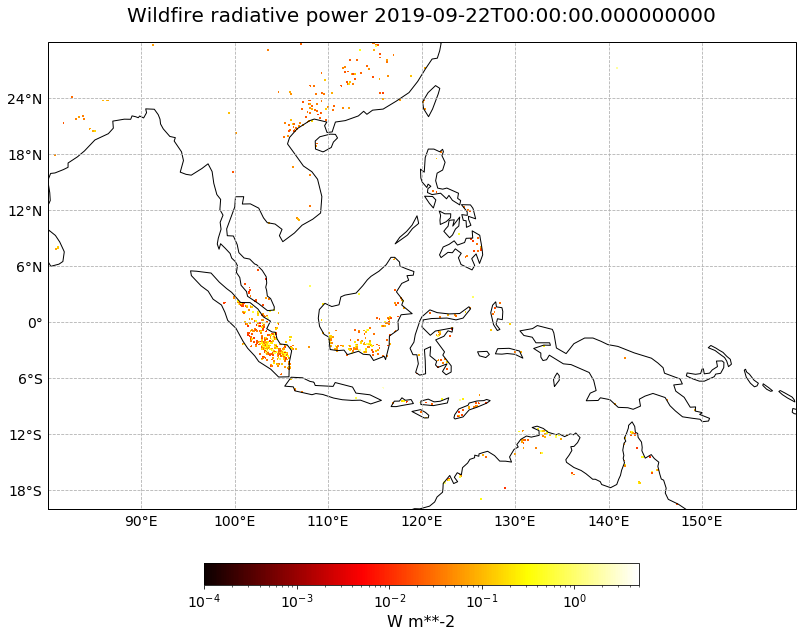

In [12]:
visualize_s5p_pcolormesh(frpfire_subset.isel(time=0).data, frpfire_subset.longitude.data, frpfire_subset.latitude.data, ccrs.PlateCarree(), 'hot', unit, longname + ' ' + str(frpfire_subset.isel(time=0).time.data), 0.0001, 5, lonmin, lonmax, latmin, latmax, log=True, set_global=False)
  

<br>

## <a id='cams_regional'></a>Example - CAMS regional forecast data

### Load CAMS station location data

CAMS data offers regional forecast and station location data in `csv`. With the help of the Python library [Pandas](https://pandas.pydata.org/) and its function `read_csv`, csv files can easily be read.
You can read the station locations and with `len()` you can see that it contains 2949 station data.

In [13]:
station_locations = 'eodata/cams/regional/CAMS_WEB_LOCATIONS_V1.csv'

locations = pd.read_csv(station_locations)
len(locations)

2949

Pandas' `head()` function allows you to get the first couple of entries of the list. This is helpful to get an overview of the csv content. You see that the csv contains station `ID`, `name`, `Country`, `Latitude` and `Longitude` information.

In [14]:
locations.head()

,ID,Name,Country,Latitude,Longitude
0,AMXX0003,Yerevan,Armenia,40.13,44.47
1,AMXX0001,Abovyan,Armenia,40.17,44.58
2,AMXX0002,Gyumri,Armenia,40.79,43.84
3,AUXX0097,Mattersburg,Austria,47.73,16.40
4,AUXX0100,Gussing,Austria,47.07,16.33


You can select a city and filter for entries for this location. Let's make an example with `Paris`. You can see that the dataset contains two entries, where the station `Name` contains the string `Paris`.

In [15]:
city = 'Paris'
locations[locations['Name'].str.contains(city)]

,ID,Name,Country,Latitude,Longitude
653,FRXX0077,Paris-Charles-De-Gaulle,France,48.87,2.33
710,FRXX0076,Paris,France,48.73,2.40


### Load CAMS regional forecast data

The same principle you can apply to load and read the regional forecast data. Let's use Pandas' `read_csv` function. By specifying a `DATE`, you can parse the file that contains the data for this specific day. Let's do an example to filter the data for `10 May 2018`.

You see that the `csv` contains measurements of `O3`, `NO2`, `SO2`, `CO`, `PM10` and `PM2.5`.

In [16]:
DATE='20180510'
DPLUS=1

datafile = 'eodata/cams/regional/CAMS_WEB_FORECAST_%s_D+%d.csv.gz'
path = datafile % (DATE, DPLUS)
aq_data = pd.read_csv(path, index_col=['ID', 'Date_Time'], parse_dates=[['Date','Time']] )
aq_data.head()

AQI     O3   NO2   SO2      CO   PM10   PM25
ID       Date_Time                                                        
ALXX0001 2018-05-11 01:00:00    2  49.31  2.23  0.96  160.87  12.79  11.84
         2018-05-11 02:00:00    2  47.74  1.91  0.94  161.70  13.38  11.97
         2018-05-11 03:00:00    2  46.72  1.64  0.93  162.34  13.64  11.91
         2018-05-11 04:00:00    2  44.59  1.46  1.10  163.71  14.06  11.78
         2018-05-11 05:00:00    2  52.69  1.74  1.30  165.78  14.29  11.01

### Visualize regional `Air Quality` forecast data for one specific station location

We can now filter the station ID for `Paris-Charles-de-Gaulle` and visualize all `Air Quality` forecast parameters for `11 May 2018`.

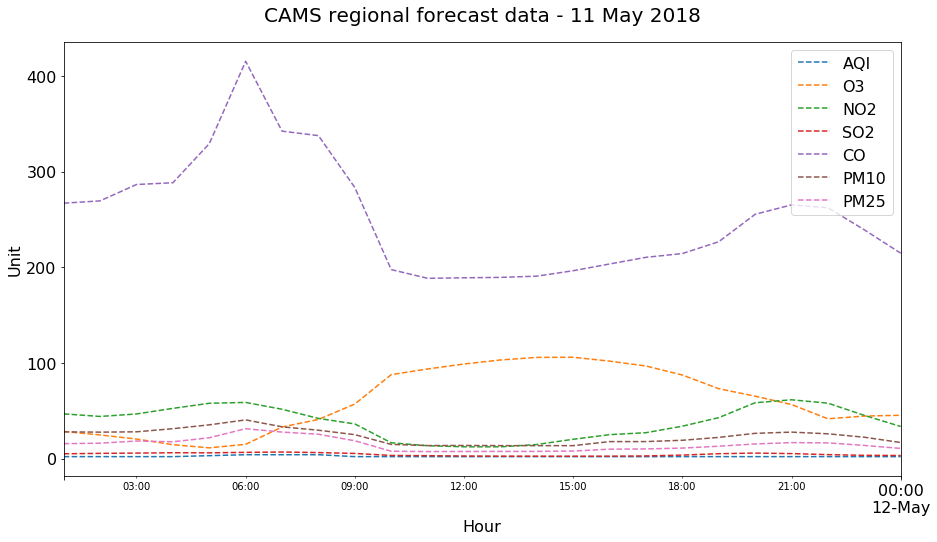

In [17]:
aq_data.loc['FRXX0077'].plot.line(figsize=(15,8),linestyle='dashed')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('CAMS regional forecast data - 11 May 2018', fontsize=20, pad=20)

plt.ylabel('Unit', fontsize=16)
plt.xlabel('Hour', fontsize=16)

plt.legend(fontsize=16,loc=1)
plt.show()

<br>

## <a id="load_ggf"></a>Load, browse and plot CAMS Greenhouse Gas Fluxes

### Load the greenhouse gas flux inversion dataset with `netCDF.Dataset`

With Python's library `netCDF` and the `Dataset` constructor, you can easily load `NetCDF` data. Let's load the data for January 1979. You can see that the dataset has two dimensions, `latitude` and `longitude` and a range of different 2-dimensional `variables`.

In [18]:
year = 1979
month_ = 1
month = "{}{:02d}".format(year, month_)
dataset = nc.Dataset("./eodata/cams/cams_ghg_fluxes/z_cams_l_lsce_{}_v18r2_ra_sfc_mm_co2flux.nc".format(month))
dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.6
    title: Global surface fluxes inferred by atmospheric inversion
    institution: LSCE (CEA/CNRS/UVSQ) - IPSL
    source: Assimilation of surface air-sample measurements
    history: 2019-07-06 18:10:42 GMT, PYVAR run by p24cheva
    references: Chevallier et al. (JGR, 2005, JGR, 2010); Chevallier (GMD, 2013)
    comment: Positive fluxes release carbon to the atmosphere
    dimensions(sizes): longitude(96), latitude(96)
    variables(dimensions): float64 flux_apri_bio(latitude,longitude), float64 flux_apri_ocean(latitude,longitude), float64 flux_apos_bio(latitude,longitude), float64 flux_apos_ocean(latitude,longitude), float64 flux_foss(latitude,longitude), float64 lsf(latitude,longitude), float64 area(latitude,longitude), float64 longitude(longitude), float64 latitude(latitude)
    groups: 

With `[]`, we can select a variable we are interested in. Let's load for example `flux_apos_bio` and `latitude` and `longitude` information to get more information about the extent.

You can see that the `flux_apos_bio` is the `Posterior land surface upward mass flux of carbon for the whole grid box and the whole month without fossile`. The variable unit is `kgC / m2 month`.

The dataset has a global extent.

In [19]:
co2_flux = dataset.variables['flux_apos_bio']
lats = dataset.variables['latitude']
lons = dataset.variables['longitude']

co2_flux, lats[:], lons[:]

(<class 'netCDF4._netCDF4.Variable'>
 float64 flux_apos_bio(latitude, longitude)
     long_name: Posterior land surface upward mass flux of carbon for the whole grid box and the whole month without fossile
     units: kgC m-2 month-1
     missing_value: -9999.0
 unlimited dimensions: 
 current shape = (96, 96)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 masked_array(data=[-90.        , -88.10526316, -86.21052632, -84.31578947,
                    -82.42105263, -80.52631579, -78.63157895, -76.73684211,
                    -74.84210526, -72.94736842, -71.05263158, -69.15789474,
                    -67.26315789, -65.36842105, -63.47368421, -61.57894737,
                    -59.68421053, -57.78947368, -55.89473684, -54.        ,
                    -52.10526316, -50.21052632, -48.31578947, -46.42105263,
                    -44.52631579, -42.63157895, -40.73684211, -38.84210526,
                    -36.94736842, -35.05263158, -33.15789474, -31.26315789,
                 

### Visualize a ghg flux inversion variable with `pcolormesh`

Now, we can plot the `Carbon upward flux` for a geographical subset, e.g. a region in Africa.

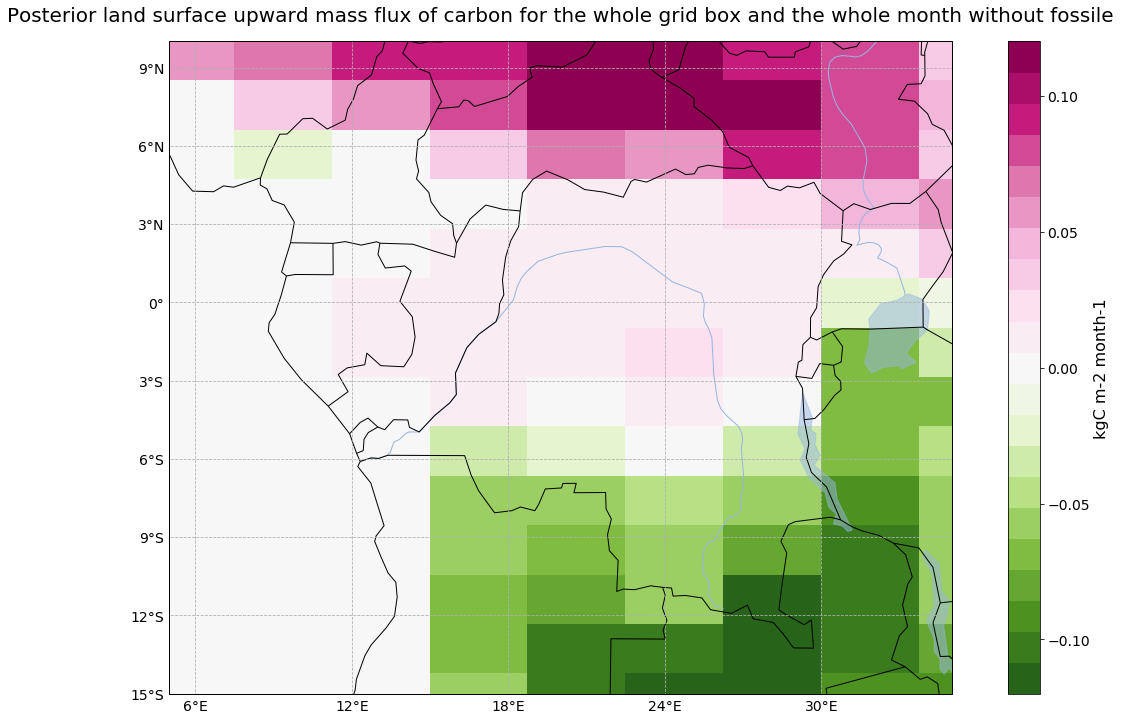

In [20]:
fig,ax = plt.subplots(figsize=(20,12))
ax = plt.axes(projection=ccrs.PlateCarree())

extent = [5, 35, -15, 10]
ax.set_extent(extent)

ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')

gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER

gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

cmap = get_cmap("PiYG_r", 21)
vmin = -.12
vmax = .12
clevs = np.arange(vmin, vmax, 0.01)
img = plt.pcolormesh(lons, lats, co2_flux[:,:], cmap=cmap, vmin=vmin, vmax=vmax)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

cbar = fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.04, pad=0.05)
cbar.set_label(co2_flux.units, fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.title(co2_flux.long_name.format(month), fontsize=20, pad=20.0)

plt.show()

<br>

<br>

<a href="./23_ltpy_Sentinel5p_L2_data.ipynb"><< 23 - Copernicus Sentinel-5 Precursor (Sentinel-5P) </a><span style="float:right;"><a href="./25_ltpy_Sentinel3_OLCI_L1.ipynb">25 - Sentinel-3 OLCI Level 1 data>></a></span>

<hr>

<p style="text-align:left;">This project is licensed under the <a href="./LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eo-lab/training-atmospheric-composition/">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:training@eumetsat.int>Contact</a></span></p>